# <center> ADAPTIVE COMPUTATION AND MACHINE LEARNING (COMS4030A)

## <center> Project: Customer Segmentation 
<center> Joshua Wacks  <center> Alex Vogt <center> Sonia Bullah

Add decription of project!

# Import and Preview Data

Add description about dataset

The following imported libraries will be used in the code:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
import missingno
pd.options.mode.chained_assignment = None  # default='warn'
import datetime
import sklearn.cluster as cluster
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

It is necessary to import as well as preview the data provided by the dataset. This can be done as follows:

In [2]:
# First, we have to read in the dataset:
df = pd.read_csv("online_retail_II.csv")
df = df.rename(columns={"Customer ID":"CustomerID"})

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])#convert to datetime

# Show the first 5 entries of the dataset:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# Show the last 5 entries of the dataset:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


In [4]:
# Obtain information on each attribute of the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   CustomerID   417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
# Get the descriptive statistics of the dataset:
df.describe()

,Quantity,Price,CustomerID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


## Data Cleaning



<AxesSubplot:>

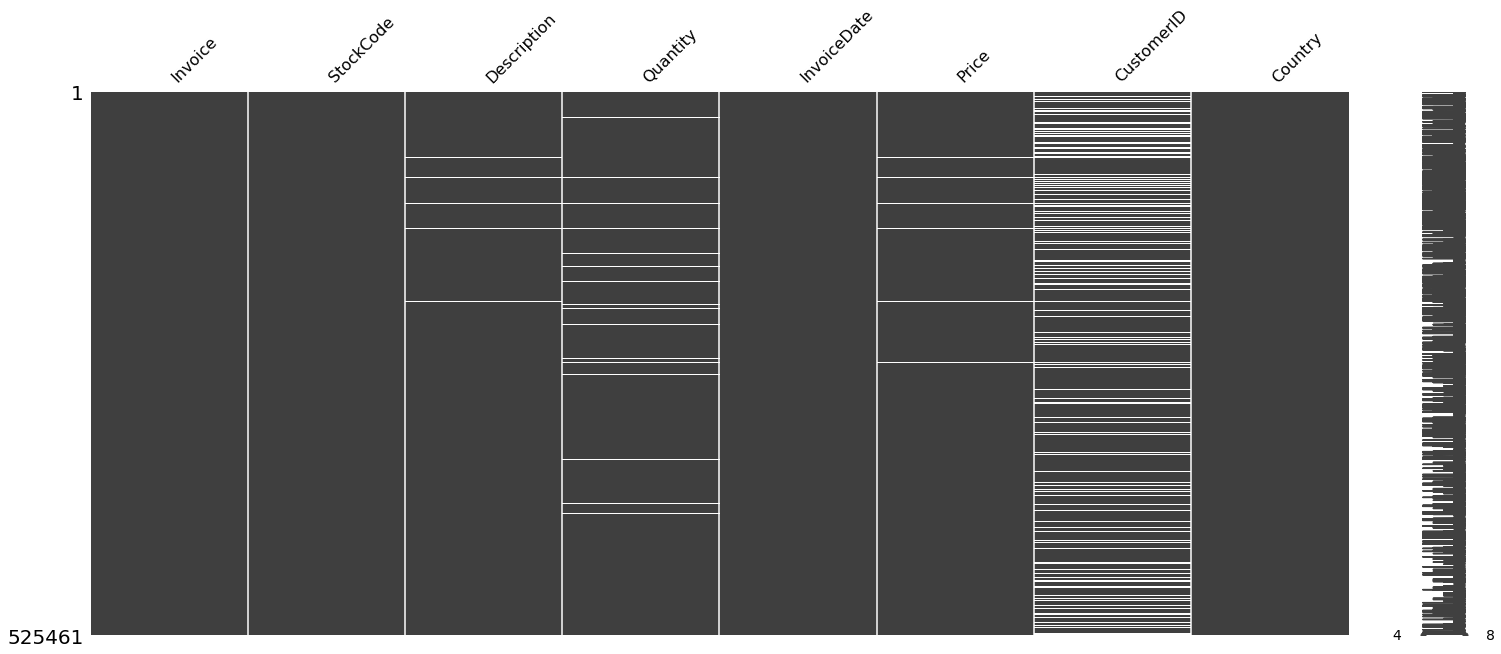

In [6]:
#Replace all the 0 and negative values with nan for two reasons
#1) To visualise the 'irrelevant' entries
#2) To treat all these nan values uniformly and drop them
df = df.replace(0,np.nan)

# Negative quantities refer to returns and that is beyond the scope of this customer segmentation
df['Price'][df['Price'] <0] = np.nan  
df['Quantity'][df['Quantity'] <0] = np.nan


missingno.matrix(df)

Therefore, there are some missing values in the dataset. Let's find out which columns contain these null values.

Quantity Column

In [7]:
# Check to see if there are any missing or 0 values in the dataset:
numNans = df['Quantity'].isna().sum()/len(df) *100
print(F"Number of nan values in the Quantity column {numNans}%. Thus we can drop these rows")
df = df[df['Quantity'].notna()]  # We only take the Quantity values that are not nan

Number of nan values in the Quantity column 2.3457497321399687%. Thus we can drop these rows


Price Column

In [8]:
# Check to see if there are any missing or 0 values in the dataset:
numNans = df['Price'].isna().sum()/len(df) *100
print(F"Number of nan values in the Price column {numNans}%. Thus we can drop these rows")
df = df[df['Price'].notna()]  # We only take the Price values that are not nan

Number of nan values in the Price column 0.3057674880879301%. Thus we can drop these rows


Customer ID Column

In [9]:
numNans = df['CustomerID'].isna().sum()/len(df) *100
print(F"The number of missing Customer IDs is only {numNans}%. Thus we can drop these rows")
df = df[df['CustomerID'].notna()]  # We only take the Customer ID values that are not nan

The number of missing Customer IDs is only 20.31057576148532%. Thus we can drop these rows


<AxesSubplot:>

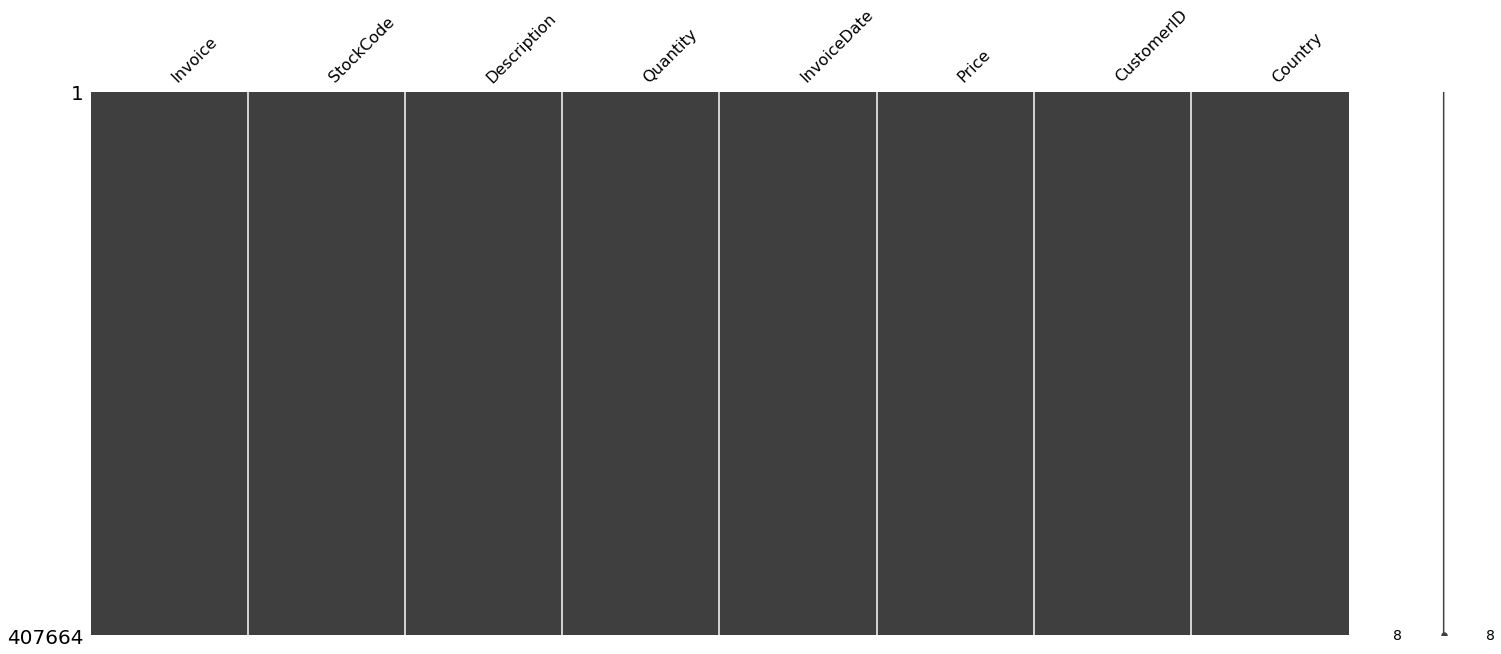

In [10]:
missingno.matrix(df)

In [11]:
df.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
dtype: int64

All the missing and irrelevant data has been removed

## Feature Selection and Engineering

Converting the descriptive data to numerical values, by means of label encoding.

In [12]:
#label encoding for non numeric features
df['Country'].value_counts()
df['Country'] = df['Country'].astype('category').cat.codes
df['Invoice'] = df['Invoice'].astype('category').cat.codes
df['StockCode'] = df['StockCode'].astype('category').cat.codes
df['Description'] = df['Description'].astype('category').cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407664 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407664 non-null  int16         
 1   StockCode    407664 non-null  int16         
 2   Description  407664 non-null  int16         
 3   Quantity     407664 non-null  float64       
 4   InvoiceDate  407664 non-null  datetime64[ns]
 5   Price        407664 non-null  float64       
 6   CustomerID   407664 non-null  float64       
 7   Country      407664 non-null  int8          
dtypes: datetime64[ns](1), float64(3), int16(3), int8(1)
memory usage: 18.3 MB


We will be using the following features\
1)Invoice\
2)StockCode\
3)Quantity\
4)Price\
5)InvoiceDate\
6)CustomerID

In [13]:
df = df[['Invoice','StockCode','Quantity','Price','InvoiceDate','CustomerID','Country']] # We drop description
df.head()

,Invoice,StockCode,Quantity,Price,InvoiceDate,CustomerID,Country
0,0,3410,12.0,6.95,2009-12-01 07:45:00,13085.0,34
1,0,2729,12.0,6.75,2009-12-01 07:45:00,13085.0,34
2,0,2731,12.0,6.75,2009-12-01 07:45:00,13085.0,34
3,0,1250,48.0,2.10,2009-12-01 07:45:00,13085.0,34
4,0,615,24.0,1.25,2009-12-01 07:45:00,13085.0,34


Filter out any of the none UK transactions

In [14]:
df = df.loc[df['Country'] == 34] 

Create an aggregated variable named Amount, by multiplying Quantity with Price, which gives the total amount of money spent per product / item in each transaction.

In [15]:
df['Amount'] = df['Quantity'] * df['Price'] # Amount = Quantity * Price
df.head()



,Invoice,StockCode,Quantity,Price,InvoiceDate,CustomerID,Country,Amount
0,0,3410,12.0,6.95,2009-12-01 07:45:00,13085.0,34,83.4
1,0,2729,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0
2,0,2731,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0
3,0,1250,48.0,2.10,2009-12-01 07:45:00,13085.0,34,100.8
4,0,615,24.0,1.25,2009-12-01 07:45:00,13085.0,34,30.0


Separate the variable InvoiceDate into two variables Date and Time. This allows different transactions created by the same consumer on the same day but at different times to be treated separately.

In [16]:
df['Date'] = df['InvoiceDate'].dt.date
df['Time'] = df['InvoiceDate'].dt.time
df.head()

,Invoice,StockCode,Quantity,Price,InvoiceDate,CustomerID,Country,Amount,Date,Time
0,0,3410,12.0,6.95,2009-12-01 07:45:00,13085.0,34,83.4,2009-12-01,07:45:00
1,0,2729,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00
2,0,2731,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00
3,0,1250,48.0,2.10,2009-12-01 07:45:00,13085.0,34,100.8,2009-12-01,07:45:00
4,0,615,24.0,1.25,2009-12-01 07:45:00,13085.0,34,30.0,2009-12-01,07:45:00


Add a season column for each transaction


In [17]:
def season_winter(month_num):
	if ((month_num == 12) | (month_num == 1) | (month_num == 2)):
		return  1 #"Winter"
	return 0

def season_spring(month_num):
	if ((month_num == 3) | (month_num == 4) | (month_num == 5)):
		return  1 #"Spring"
	return 0

def season_summer(month_num):
	if ((month_num == 6) | (month_num == 7) | (month_num == 8)):
		return  1 #"Summer"
	return 0

def season_autumn(month_num):
	if ((month_num == 9) | (month_num == 10) | (month_num == 11)):
		return  1 #"Autumn"
	return 0

df['Season0'] = df.apply(lambda x: season_winter(x['Date'].month),axis=1)
df['Season1'] = df.apply(lambda x: season_spring(x['Date'].month),axis=1)
df['Season2'] = df.apply(lambda x: season_summer(x['Date'].month),axis=1)
df['Season3'] = df.apply(lambda x: season_autumn(x['Date'].month),axis=1)

df.head()

,Invoice,StockCode,Quantity,Price,InvoiceDate,CustomerID,Country,Amount,Date,Time,Season0,Season1,Season2,Season3
0,0,3410,12.0,6.95,2009-12-01 07:45:00,13085.0,34,83.4,2009-12-01,07:45:00,1,0,0,0
1,0,2729,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00,1,0,0,0
2,0,2731,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00,1,0,0,0
3,0,1250,48.0,2.10,2009-12-01 07:45:00,13085.0,34,100.8,2009-12-01,07:45:00,1,0,0,0
4,0,615,24.0,1.25,2009-12-01 07:45:00,13085.0,34,30.0,2009-12-01,07:45:00,1,0,0,0


Create 4 new columns: Recency, Frequency, Total_Amount, Season_Total

Adding a season colums

In [18]:
season_arr = ["Season0","Season1","Season2","Season3"]
season_arr_total = ["Season0Total","Season1Total","Season2Total","Season3Total"]


for sn,head in zip(season_arr,season_arr_total):
    df[head] = df.groupby('CustomerID')[sn].transform('sum')    

df.drop(columns=season_arr,inplace=True)
df.head()

,Invoice,StockCode,Quantity,Price,InvoiceDate,CustomerID,Country,Amount,Date,Time,Season0Total,Season1Total,Season2Total,Season3Total
0,0,3410,12.0,6.95,2009-12-01 07:45:00,13085.0,34,83.4,2009-12-01,07:45:00,62,0,0,0
1,0,2729,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00,62,0,0,0
2,0,2731,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00,62,0,0,0
3,0,1250,48.0,2.10,2009-12-01 07:45:00,13085.0,34,100.8,2009-12-01,07:45:00,62,0,0,0
4,0,615,24.0,1.25,2009-12-01 07:45:00,13085.0,34,30.0,2009-12-01,07:45:00,62,0,0,0


Adding a time of day integer column

In [19]:
def get_minutes(t):
    return (t.hour * 60 + t.minute) + t.second % 60

df['Minutes'] = df.apply(lambda x: get_minutes(x['Time']),axis=1)

df.head()

,Invoice,StockCode,Quantity,Price,InvoiceDate,CustomerID,Country,Amount,Date,Time,Season0Total,Season1Total,Season2Total,Season3Total,Minutes
0,0,3410,12.0,6.95,2009-12-01 07:45:00,13085.0,34,83.4,2009-12-01,07:45:00,62,0,0,0,465
1,0,2729,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00,62,0,0,0,465
2,0,2731,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00,62,0,0,0,465
3,0,1250,48.0,2.10,2009-12-01 07:45:00,13085.0,34,100.8,2009-12-01,07:45:00,62,0,0,0,465
4,0,615,24.0,1.25,2009-12-01 07:45:00,13085.0,34,30.0,2009-12-01,07:45:00,62,0,0,0,465


In [20]:
df_minutes = df.drop_duplicates('Invoice')

Total_Amount Column

In [21]:
df['Total_Amount'] = df.groupby('CustomerID')['Amount'].transform('sum')
df['Min'] = df.groupby('CustomerID')['Amount'].transform('min')
df['Max'] = df.groupby('CustomerID')['Amount'].transform('max')
df['Avg'] = df.groupby('CustomerID')['Amount'].transform('mean')
df['avg_time_minutes'] = df.groupby('CustomerID')['Minutes'].transform('mean')

df.head()

,Invoice,StockCode,Quantity,Price,InvoiceDate,CustomerID,Country,Amount,Date,Time,Season0Total,Season1Total,Season2Total,Season3Total,Minutes,Total_Amount,Min,Max,Avg,avg_time_minutes
0,0,3410,12.0,6.95,2009-12-01 07:45:00,13085.0,34,83.4,2009-12-01,07:45:00,62,0,0,0,465,2017.2,10.2,100.8,32.535484,662.467742
1,0,2729,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00,62,0,0,0,465,2017.2,10.2,100.8,32.535484,662.467742
2,0,2731,12.0,6.75,2009-12-01 07:45:00,13085.0,34,81.0,2009-12-01,07:45:00,62,0,0,0,465,2017.2,10.2,100.8,32.535484,662.467742
3,0,1250,48.0,2.10,2009-12-01 07:45:00,13085.0,34,100.8,2009-12-01,07:45:00,62,0,0,0,465,2017.2,10.2,100.8,32.535484,662.467742
4,0,615,24.0,1.25,2009-12-01 07:45:00,13085.0,34,30.0,2009-12-01,07:45:00,62,0,0,0,465,2017.2,10.2,100.8,32.535484,662.467742


Recency Column

In [22]:
simulated_date = datetime.date(2011,1,1)
df.sort_values(by='InvoiceDate',ascending=False).groupby('CustomerID')
df['Recency'] = (simulated_date.year - pd.DatetimeIndex(df['Date']).year) * 12  + (simulated_date.month - pd.DatetimeIndex(df['Date']).month)
df['Recency'] = df['Recency'] 

res = df.groupby(['CustomerID']).apply(lambda x:x['Recency'].min())  # Get the recency for each customer


Frequency Column

In [23]:
freq = df.groupby(['CustomerID','Invoice']).size().reset_index(drop=False).groupby('CustomerID')[[0]].count()  # Get the frequency for each customer

Condensing table contents per user

In [24]:
mon =  df.groupby(['CustomerID'])['Total_Amount'].unique().astype(float)
min =  df.groupby(['CustomerID'])['Min'].unique().astype(float)
max =  df.groupby(['CustomerID'])['Max'].unique().astype(float)
mean =  df.groupby(['CustomerID'])['Avg'].unique().astype(float)

season0 = df.groupby(['CustomerID'])['Season0Total'].unique().astype(int)
season1 = df.groupby(['CustomerID'])['Season1Total'].unique().astype(int)
season2 = df.groupby(['CustomerID'])['Season2Total'].unique().astype(int)
season3 = df.groupby(['CustomerID'])['Season3Total'].unique().astype(int)

avg_minutes = df.groupby(['CustomerID'])['avg_time_minutes'].unique().astype(float)

df_customer = pd.DataFrame({'Recency':res,'Frequency':freq[0],'Total_Spent':mon,
                       'Min_Spent':min,'Max_Spent':max,'Mean_Spent':mean,
                       'Season0':season0,'Season1':season1,'Season2':season2,'Season3':season3,
                       'Avg_Time_Minutes': avg_minutes})

df_customer['Popular_Season'] = df_customer[['Season0','Season1','Season2','Season3']].idxmax(axis =1) # Get the most popular season for that customer
df_customer.head() # This df_customer has info pertaining to each individual customer only

,Recency,Frequency,Total_Spent,Min_Spent,Max_Spent,Mean_Spent,Season0,Season1,Season2,Season3,Avg_Time_Minutes,Popular_Season
CustomerID,,,,,,,,,,,,
12346.0,7,11,372.86,1.00,45.00,11.298788,9,5,19,0,778.848485,Season2
12608.0,3,1,415.79,0.95,162.24,25.986875,0,0,0,16,649.000000,Season3
12745.0,5,2,723.85,10.08,102.00,32.902273,0,10,12,0,794.000000,Season2
12746.0,7,1,254.55,12.60,17.70,14.973529,0,0,17,0,641.000000,Season2
12747.0,1,16,5080.53,2.25,381.60,32.990455,43,35,43,33,807.714286,Season0


In [25]:
df_customer['Popular_Season'] = df_customer['Popular_Season'].astype('category').cat.codes
df_customer.head()


,Recency,Frequency,Total_Spent,Min_Spent,Max_Spent,Mean_Spent,Season0,Season1,Season2,Season3,Avg_Time_Minutes,Popular_Season
CustomerID,,,,,,,,,,,,
12346.0,7,11,372.86,1.00,45.00,11.298788,9,5,19,0,778.848485,2
12608.0,3,1,415.79,0.95,162.24,25.986875,0,0,0,16,649.000000,3
12745.0,5,2,723.85,10.08,102.00,32.902273,0,10,12,0,794.000000,2
12746.0,7,1,254.55,12.60,17.70,14.973529,0,0,17,0,641.000000,2
12747.0,1,16,5080.53,2.25,381.60,32.990455,43,35,43,33,807.714286,0


### Outlier Detection

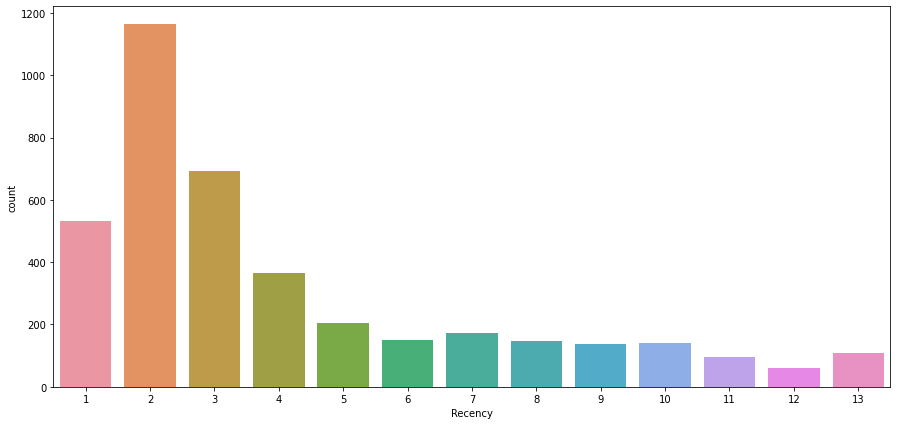

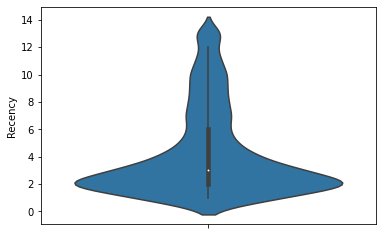

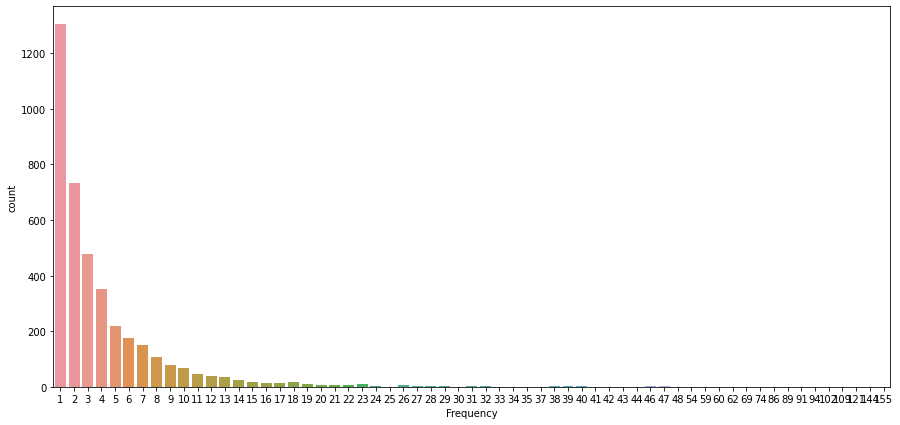

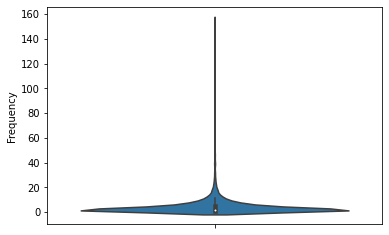

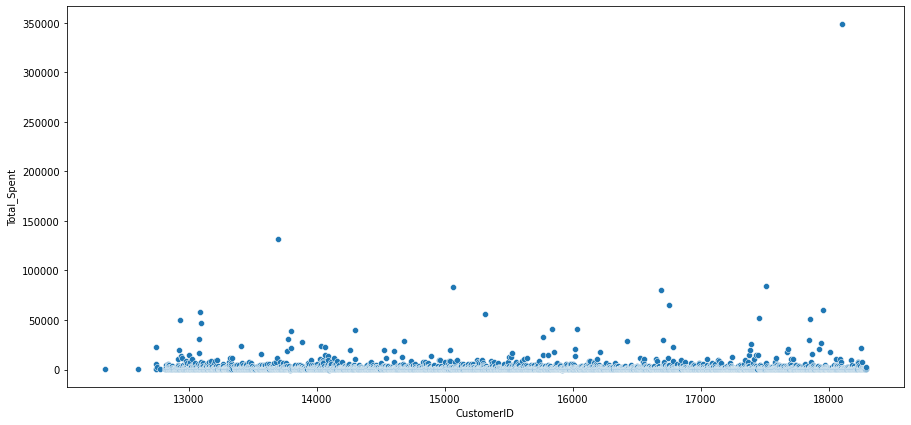

In [26]:
def outlier_subplots():
	for clm in ['Recency','Frequency']:
		plt.figure(figsize=(15,7))
		sns.countplot(data = df_customer, x = clm)
		plt.show()
	
		sns.violinplot(data = df_customer, y = clm)
		plt.show()
	
	plt.figure(figsize=(15,7))	
 
	sns.scatterplot(data = df_customer.Total_Spent)
	plt.show()
outlier_subplots()


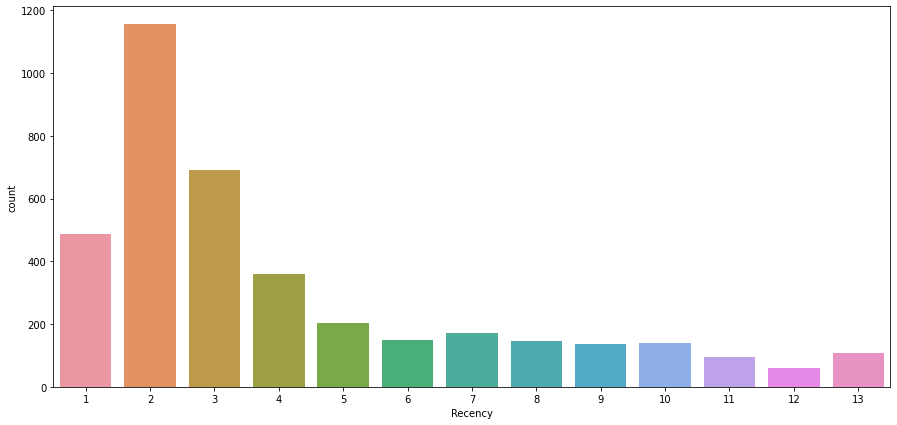

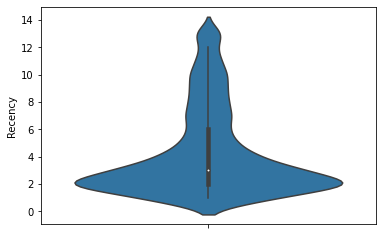

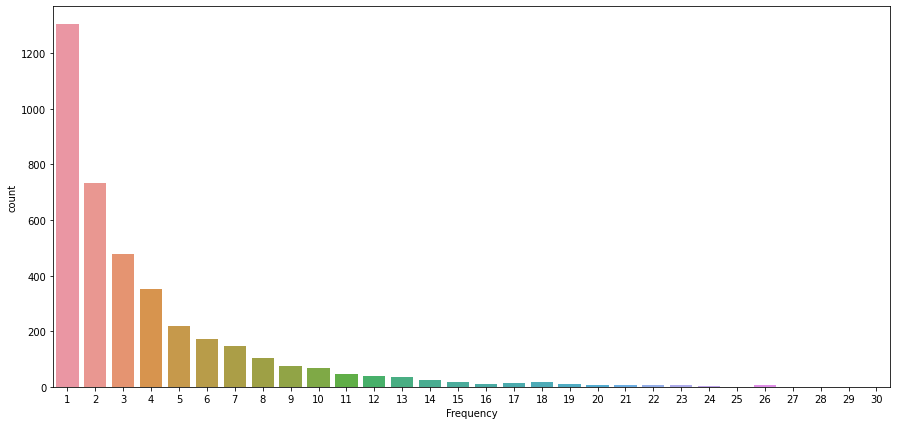

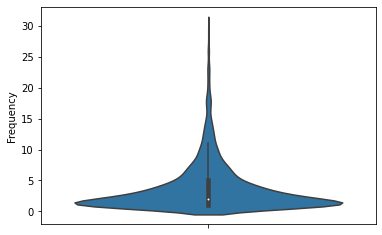

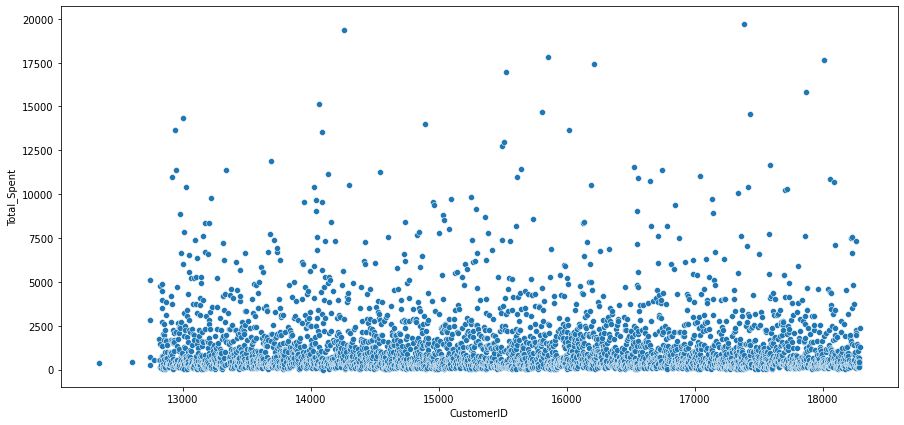

<AxesSubplot:xlabel='Total_Spent', ylabel='Count'>

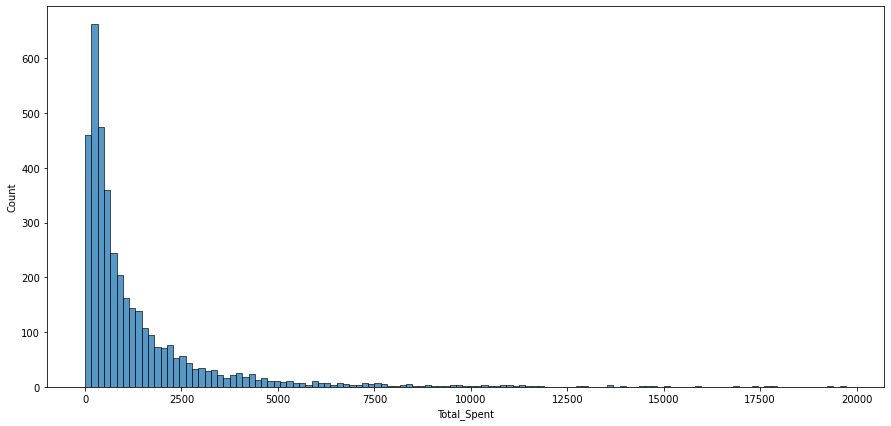

In [27]:
def remove_outliers():
	condition = df_customer.index[df_customer['Frequency'] > 30]
	df_customer.drop(condition, inplace=True)
 
	condition = df_customer.index[df_customer['Total_Spent'] > 20000]
	df_customer.drop(condition, inplace=True)

 
remove_outliers()
outlier_subplots()
plt.figure(figsize=(15,7))
sns.histplot(data = df_customer['Total_Spent'])

### Normalising

In [29]:
df_customer_old = df_customer.copy() #Need to make a copy to store old max and min values
def normalise_min_max():
	for clm in df_customer.columns:
		X_scaled = (df_customer[clm] - df_customer[clm].min(axis=0)) / (df_customer[clm].max(axis=0) - df_customer[clm].min(axis=0))
		df_customer[clm] = X_scaled
normalise_min_max()


df_customer.head()
df_customer_old.head()

,Recency,Frequency,Total_Spent,Min_Spent,Max_Spent,Mean_Spent,Season0,Season1,Season2,Season3,Avg_Time_Minutes,Popular_Season
CustomerID,,,,,,,,,,,,
12346.0,7,11,372.86,1.00,45.00,11.298788,9,5,19,0,778.848485,2
12608.0,3,1,415.79,0.95,162.24,25.986875,0,0,0,16,649.000000,3
12745.0,5,2,723.85,10.08,102.00,32.902273,0,10,12,0,794.000000,2
12746.0,7,1,254.55,12.60,17.70,14.973529,0,0,17,0,641.000000,2
12747.0,1,16,5080.53,2.25,381.60,32.990455,43,35,43,33,807.714286,0


In [30]:
def undo_normalising(x,xMin,xMax):
    return x*(xMax - xMin) + xMin

## Clustering

### Plotting

In [31]:
%matplotlib widget
def three_d_scatter(df_clusters,num_clusters,labels):
	sns.set(style = "darkgrid")
	fig = plt.figure(figsize=(15,7))
	# ax = fig.add_subplot(111, projection = '3d')
	ax = Axes3D(fig)
	if num_clusters == 0:
		num_clusters = df_clusters['cluster'].max() - df_clusters['cluster'].min()
	
	print(num_clusters)
	ax.set_xlabel(labels[0])
	ax.set_ylabel(labels[1])
	ax.set_zlabel(labels[2])
 
	color_arr = ['blue','red','green','black','orange','purple','yellow']
	shape_arr = ['.','x','^','*','o','s','d']
	

	for i in range(num_clusters):
		x = df_clusters[labels[0]].where(df_clusters['cluster'] == i)
		y = df_clusters[labels[1]].where(df_clusters['cluster'] == i)
		z = df_clusters[labels[2]].where(df_clusters['cluster'] == i)

		ax.scatter( x, y, z,color = color_arr[i], s = 20,marker = shape_arr[i],label = F" Cluster {i}")
	
	plt.legend()
	plt.show()

In [32]:
def cluster_analysis(df_clusters,num_centres,labels,num_dim):
	table =  PrettyTable()
	table.field_names = ["Cluster","Mean","Max","Min"]
	clmns = {}
	for i in range(num_centres):
		column1 = df_clusters[labels[0]].loc[df_clusters['cluster'] == i]
		label1 = labels[0] + str(i)
  
		column2 = df_clusters[labels[1]].loc[df_clusters['cluster'] == i]
		label2 = labels[1] + str(i)
  
		clmns[label1] = column1
		clmns[label2] = column2
  
		if num_dim == 3:
			column3 = df_clusters[labels[2]].loc[df_clusters['cluster'] == i]
			label3 = labels[2] + str(i)
			clmns[label3] = column3

		# table.add_row([F"Cluster {i}:",'','',''])


	for i,clm in enumerate(clmns):
		if i % num_dim  == 0:
			table.add_row([F"Cluster {clm[-1]}:",'','',''])
			
		label = clm[:-1]
		clm = clmns[clm]
		cluster_mean = clm.mean()
		cluster_max = clm.max()
		cluster_min = clm.min()
		original_mean = undo_normalising(cluster_mean,df_customer_old[label].min(axis=0),df_customer_old[label].max(axis=0))
		original_max = undo_normalising(cluster_max,df_customer_old[label].min(axis=0),df_customer_old[label].max(axis=0))
		original_min = undo_normalising(cluster_min,df_customer_old[label].min(axis=0),df_customer_old[label].max(axis=0))
		original_mean = np.round(original_mean,2)
		original_max = np.round(original_max,2)
		original_min = np.round(original_min,2)

		table.add_row([label,original_mean,original_max,original_min])
		# table.add_row([label,cluster_mean,cluster_max,cluster_min])
  
  
	print(table)
    
    

### K-MEANS

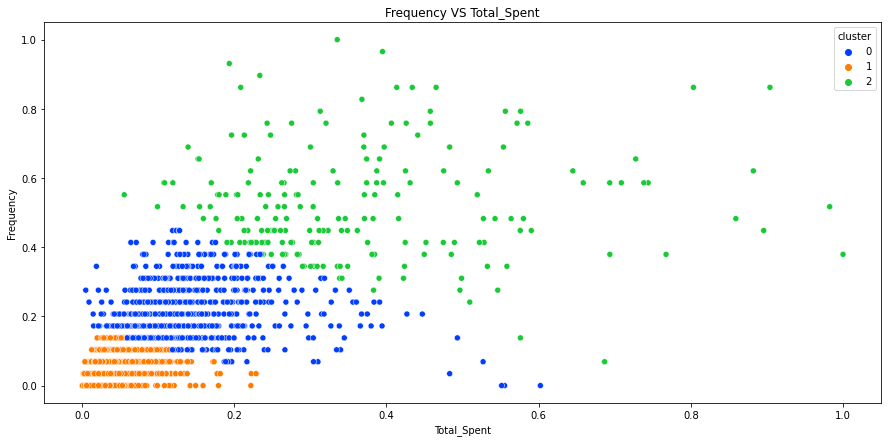

+-------------+---------+----------+---------+
|   Cluster   |   Mean  |   Max    |   Min   |
+-------------+---------+----------+---------+
|  Cluster 0: |         |          |         |
| Total_Spent |  2612.8 | 11880.84 |   97.4  |
|  Frequency  |   7.18  |   14.0   |   1.0   |
|  Cluster 1: |         |          |         |
| Total_Spent |  596.56 | 4511.76  |   2.95  |
|  Frequency  |   2.0   |   5.0    |   1.0   |
|  Cluster 2: |         |          |         |
| Total_Spent | 7234.11 | 19726.76 | 1094.39 |
|  Frequency  |   16.2  |   30.0   |   3.0   |
+-------------+---------+----------+---------+


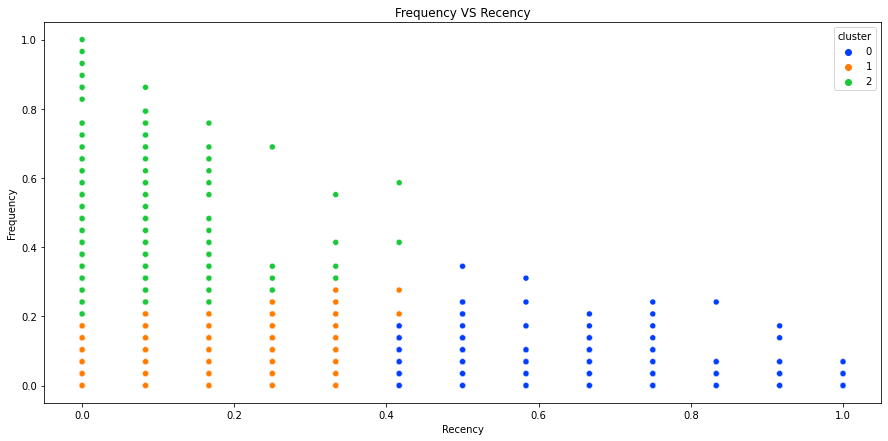

+------------+------+------+-----+
|  Cluster   | Mean | Max  | Min |
+------------+------+------+-----+
| Cluster 0: |      |      |     |
|  Recency   | 9.03 | 13.0 | 6.0 |
| Frequency  | 1.7  | 11.0 | 1.0 |
| Cluster 1: |      |      |     |
|  Recency   | 2.71 | 6.0  | 1.0 |
| Frequency  | 2.93 | 9.0  | 1.0 |
| Cluster 2: |      |      |     |
|  Recency   | 1.74 | 6.0  | 1.0 |
| Frequency  | 11.9 | 30.0 | 7.0 |
+------------+------+------+-----+


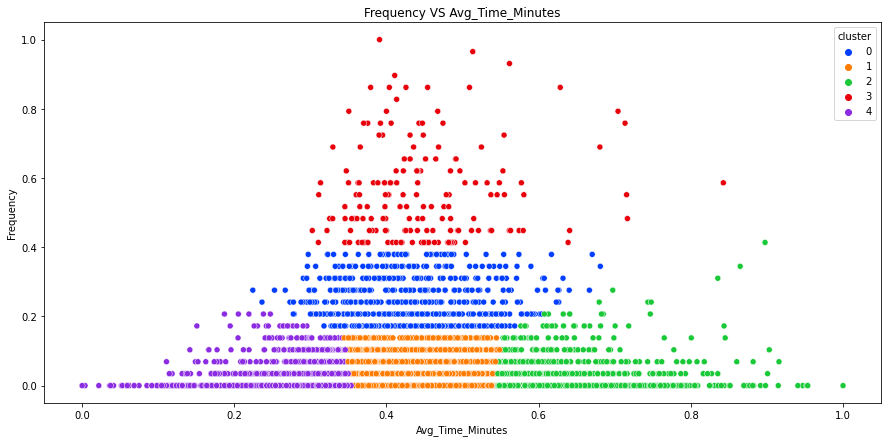

+------------------+--------+---------+--------+
|     Cluster      |  Mean  |   Max   |  Min   |
+------------------+--------+---------+--------+
|    Cluster 0:    |        |         |        |
| Avg_Time_Minutes | 788.27 |  979.79 | 625.85 |
|    Frequency     |  8.16  |   12.0  |  6.0   |
|    Cluster 1:    |        |         |        |
| Avg_Time_Minutes | 795.59 |  877.23 | 718.33 |
|    Frequency     |  2.46  |   5.0   |  1.0   |
|    Cluster 2:    |        |         |        |
| Avg_Time_Minutes | 954.29 |  1227.0 | 874.0  |
|    Frequency     |  2.07  |   13.0  |  1.0   |
|    Cluster 3:    |        |         |        |
| Avg_Time_Minutes | 798.17 | 1105.08 | 686.42 |
|    Frequency     |  17.2  |   30.0  |  13.0  |
|    Cluster 4:    |        |         |        |
| Avg_Time_Minutes | 652.31 |  726.0  | 452.0  |
|    Frequency     |  2.07  |   7.0   |  1.0   |
+------------------+--------+---------+--------+


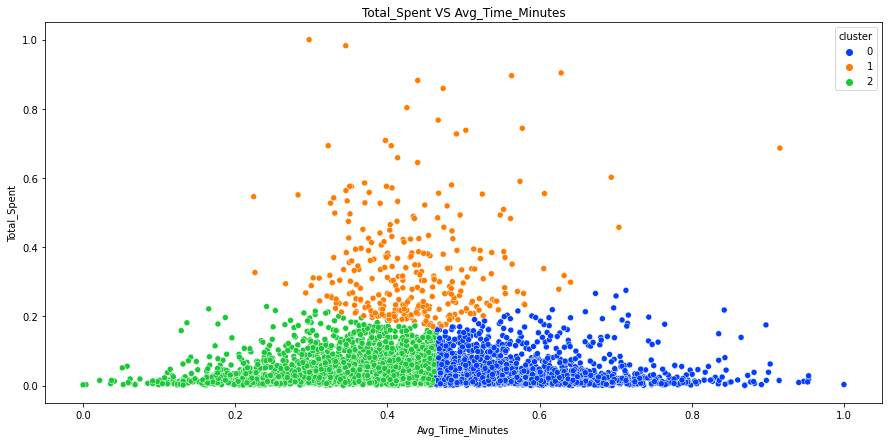

+------------------+---------+----------+---------+
|     Cluster      |   Mean  |   Max    |   Min   |
+------------------+---------+----------+---------+
|    Cluster 0:    |         |          |         |
| Avg_Time_Minutes |  901.95 |  1227.0  |  810.0  |
|   Total_Spent    |  851.29 | 5434.13  |   3.75  |
|    Cluster 1:    |         |          |         |
| Avg_Time_Minutes |  789.49 | 1161.76  |  625.85 |
|   Total_Spent    | 6634.68 | 19726.76 | 3374.22 |
|    Cluster 2:    |         |          |         |
| Avg_Time_Minutes |  718.93 |  812.16  |  452.0  |
|   Total_Spent    |  956.6  | 4511.76  |   2.95  |
+------------------+---------+----------+---------+


In [33]:
def k_means_2_Features():
	%matplotlib inline
	num_centres = [3,3,5,3,3]
	comparison_arr =[['Total_Spent','Frequency'],['Recency','Frequency'],['Avg_Time_Minutes','Frequency'],['Avg_Time_Minutes','Total_Spent']]
	for nc,comp in zip(num_centres,comparison_arr):
     
		np_array = df_customer[comp].to_numpy()
		kmeans = cluster.KMeans(n_clusters=nc,random_state=42).fit(np_array)
		df_clusters = df_customer.copy()
		df_clusters['cluster'] = kmeans.labels_
 
		plt.figure(figsize=(15,7))
		sns.scatterplot( x = df_clusters[comp[0]],y = df_clusters[comp[1]], hue = df_clusters['cluster'],palette="bright")
		plt.title(F"{comp[1]} VS {comp[0]}")
		plt.show()
		cluster_analysis(df_clusters,nc,comp,2)
k_means_2_Features()

3


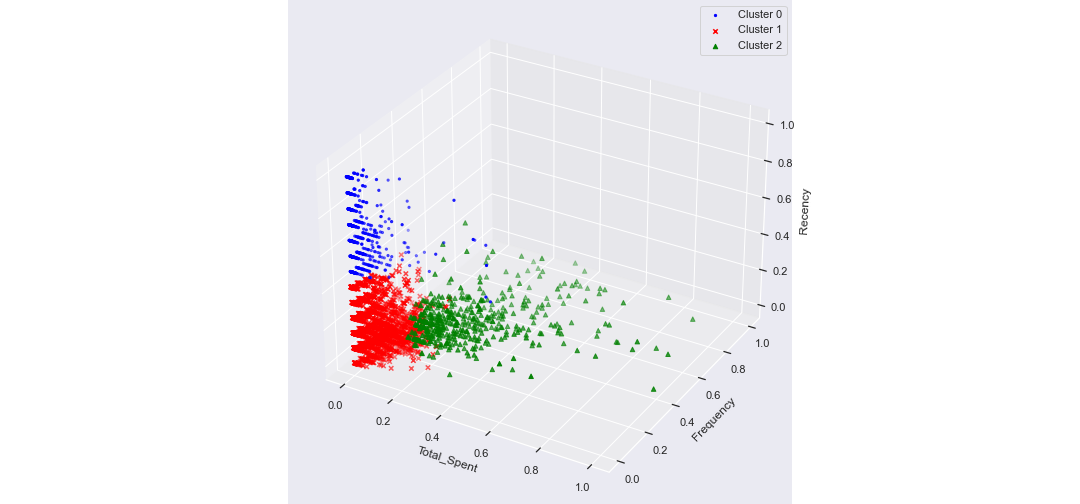

+-------------+---------+----------+---------+
|   Cluster   |   Mean  |   Max    |   Min   |
+-------------+---------+----------+---------+
|  Cluster 0: |         |          |         |
| Total_Spent |  534.96 | 10953.5  |   2.95  |
|  Frequency  |   1.62  |   11.0   |   1.0   |
|   Recency   |   9.53  |   13.0   |   7.0   |
|  Cluster 1: |         |          |         |
| Total_Spent |  936.13 | 6701.64  |   3.75  |
|  Frequency  |   2.94  |   10.0   |   1.0   |
|   Recency   |   2.88  |   6.0    |   1.0   |
|  Cluster 2: |         |          |         |
| Total_Spent | 4888.02 | 19726.76 | 1094.39 |
|  Frequency  |  11.96  |   30.0   |   1.0   |
|   Recency   |   1.81  |   6.0    |   1.0   |
+-------------+---------+----------+---------+
4


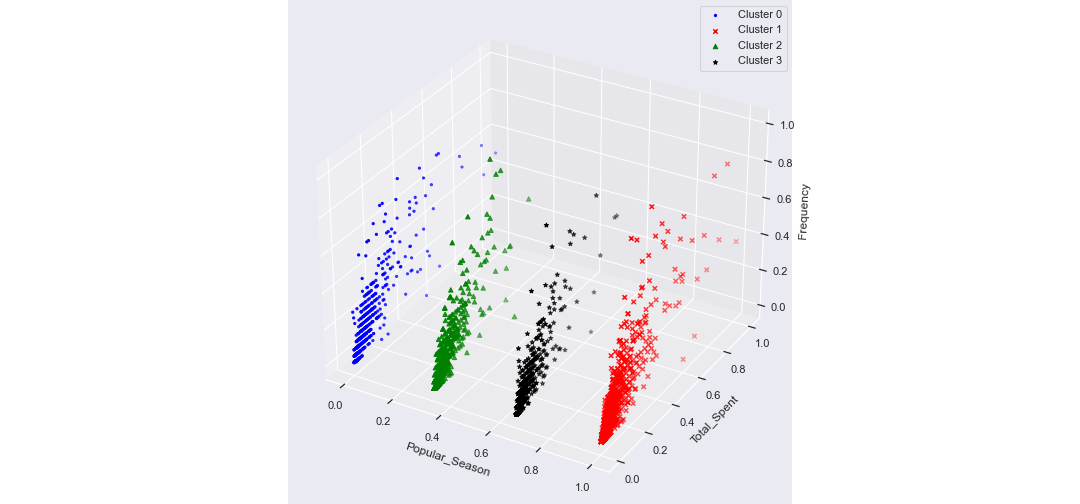

+----------------+---------+----------+-------+
|    Cluster     |   Mean  |   Max    |  Min  |
+----------------+---------+----------+-------+
|   Cluster 0:   |         |          |       |
| Popular_Season |   0.0   |   0.0    |  0.0  |
|  Total_Spent   | 1524.06 | 19381.36 |  2.95 |
|   Frequency    |   4.33  |   24.0   |  1.0  |
|   Cluster 1:   |         |          |       |
| Popular_Season |   3.0   |   3.0    |  3.0  |
|  Total_Spent   | 1308.77 | 19726.76 | 10.95 |
|   Frequency    |   3.59  |   30.0   |  1.0  |
|   Cluster 2:   |         |          |       |
| Popular_Season |   1.0   |   1.0    |  1.0  |
|  Total_Spent   | 1337.77 | 12992.33 | 17.65 |
|   Frequency    |   3.82  |   29.0   |  1.0  |
|   Cluster 3:   |         |          |       |
| Popular_Season |   2.0   |   2.0    |  2.0  |
|  Total_Spent   | 1294.19 | 13980.83 |  3.75 |
|   Frequency    |   3.69  |   26.0   |  1.0  |
+----------------+---------+----------+-------+
3


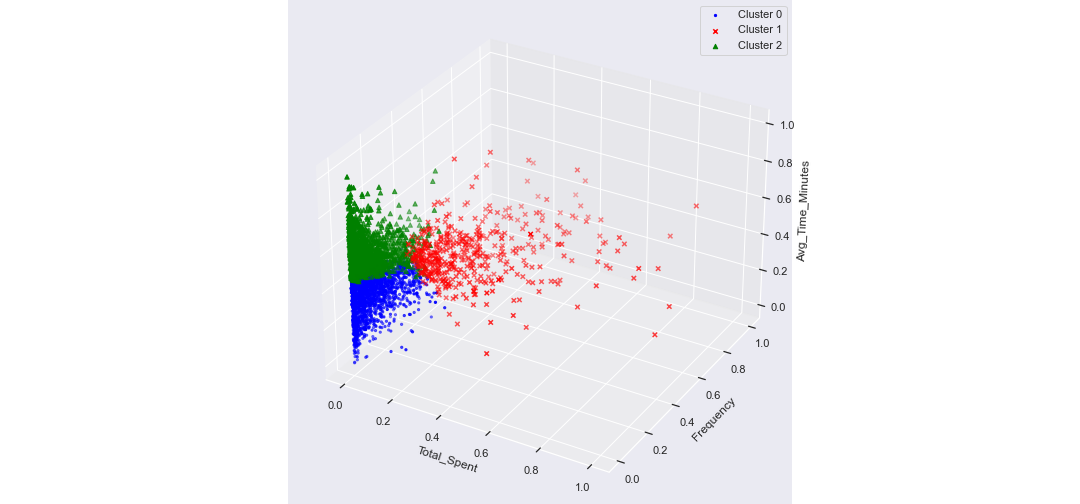

+------------------+---------+----------+--------+
|     Cluster      |   Mean  |   Max    |  Min   |
+------------------+---------+----------+--------+
|    Cluster 0:    |         |          |        |
|   Total_Spent    |  885.14 | 6116.92  |  2.95  |
|    Frequency     |   2.76  |   9.0    |  1.0   |
| Avg_Time_Minutes |  716.09 |  812.35  | 452.0  |
|    Cluster 1:    |         |          |        |
|   Total_Spent    | 5120.41 | 19726.76 | 372.86 |
|    Frequency     |  12.14  |   30.0   |  1.0   |
| Avg_Time_Minutes |  792.95 | 1161.76  | 625.85 |
|    Cluster 2:    |         |          |        |
|   Total_Spent    |  768.07 | 5259.99  |  3.75  |
|    Frequency     |   2.52  |   11.0   |  1.0   |
| Avg_Time_Minutes |  901.61 |  1227.0  | 807.0  |
+------------------+---------+----------+--------+


In [34]:
def k_means_3_Features():
	%matplotlib widget
	num_centres = [3,4,3]
	comparison_arr = [['Total_Spent','Frequency','Recency'],['Popular_Season','Total_Spent','Frequency'],['Total_Spent','Frequency','Avg_Time_Minutes']]

	for nc,comp in zip(num_centres,comparison_arr):
		np_array = df_customer[comp].to_numpy()
		kmeans = cluster.KMeans(n_clusters=nc,random_state=42).fit(np_array)
		df_clusters = df_customer.copy()
		df_clusters['cluster'] = kmeans.labels_
		three_d_scatter(df_clusters,nc,comp)
		cluster_analysis(df_clusters,nc,comp,3)
  
k_means_3_Features()
